In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore','.*')

In [3]:
from IPython import display

In [4]:
import cStringIO as StringIO
from PIL import Image

In [5]:
import numpy as np
import matplotlib.pyplot as pl
from path import Path
import pandas as pd
import cv2

In [6]:
import theano
import theano.tensor as T
import lasagne
import scipy.io

Using gpu device 0: Tesla K40c


In [7]:
import pydnn
import aman_sandbox
import pyimg
from aman_sandbox.pseudofcn_rgbd import PseudoFcn_RGBD
#from pydnn.models.pseudofcn import PseudoFcn8_2
#from pydnn.expr2d import masked_error_rate_2d
import scipy.io

In [8]:
#Creating list to store the path of image and structured_labes
image_frames = []
gt_image_frames = []
hha_image_frames = []

In [9]:
#Base directory where data is available
base_dir = Path('/home/aman/data/NYUv2_HHA/')
#for color mapping of labels and prediction
rgb_to_dict = {}
rgb_to_dict[0] = np.array((255,255,0), np.uint8) #yellow(void)
rgb_to_dict[1] = np.array((255, 128, 0), np.uint8) #orange
rgb_to_dict[2] = np.array((0,255,0), np.uint8) #green
rgb_to_dict[3] = np.array((0,0,255), np.uint8) #blue
rgb_to_dict[4] = np.array((255,0,255), np.uint8) #pink
rgb_remapper = pyimg.cyimg.RgbRemapper(rgb_to_dict)

In [10]:
# Getting all the pathes of files reading frome each directory
for i in xrange(0,1449):
    dir_num = "%05d" % i
    base_dir_current = base_dir + str(dir_num)
    image_frames.append(base_dir_current.files('image.jpg'))
    gt_image_frames.append(base_dir_current.files('structure_labels.png'))
    hha_image_frames.append(base_dir_current.files('HHA.png'))

#print 'Length of image_frame:', image_frames.__len__()
#print 'Length of gt_image_frame:', gt_image_frames.__len__()
#print 'Length of dp_image_frame:', dp_image_frames.__len__()
                           

In [11]:
#Loading the split data
split = scipy.io.loadmat('splits.mat')
testNdxs = split.pop('testNdxs')
trainNdxs =  split.pop('trainNdxs')

In [12]:
print 'testing data length:', testNdxs.__len__()
print 'training data length:', trainNdxs.__len__()
test_idx = testNdxs.flatten()
train_idx = trainNdxs.flatten()
test_idx -= 1
train_idx -= 1

testing data length: 654
training data length: 795


In [13]:
image_frames = sum(image_frames,[])
gt_image_frames = sum(gt_image_frames,[])
hha_image_frames = sum(hha_image_frames, [])
print 'Length of image_frames:', image_frames.__len__()
print 'Length of gt_frames:', gt_image_frames.__len__()
print 'Length of hha_frames:', hha_image_frames.__len__()
N = len(image_frames)
#rng = np.random.RandomState(seed=28)
#shuffle_idx = rng.permutation(N)
#train_idx, test_idx = shuffle_idx[:-4], shuffle_idx[-4:]
#print len(train_idx), len(test_idx)

Length of image_frames: 1449
Length of gt_frames: 1449
Length of hha_frames: 1449


In [14]:
N_train = len(train_idx)
N_test = len(test_idx)

In [15]:
label_df = 5 #number of categories with void
batch_size = 4
num_class = label_df-1 #Acutal number of classes
model = PseudoFcn_RGBD(batch_size, num_class)

In [16]:
layers = lasagne.layers.helper.get_all_layers(model.l_out)
for layer in layers:
    print layer.name, layer.get_output_shape()

None (4, 6, 500, 500)
conv1_1 (4, 64, 698, 698)
conv1_2 (4, 64, 698, 698)
pool1 (4, 64, 349, 349)
conv2_1 (4, 128, 349, 349)
conv2_2 (4, 128, 349, 349)
pool2 (4, 128, 174, 174)
conv3_1 (4, 256, 174, 174)
conv3_2 (4, 256, 174, 174)
conv3_3 (4, 256, 174, 174)
pool3 (4, 256, 87, 87)
conv4_1 (4, 512, 87, 87)
conv4_2 (4, 512, 87, 87)
conv4_3 (4, 512, 87, 87)
pool4 (4, 512, 43, 43)
conv5_1 (4, 512, 43, 43)
conv5_2 (4, 512, 43, 43)
conv5_3 (4, 512, 43, 43)
pool5 (4, 512, 21, 21)
conv6_1 (4, 4096, 21, 21)
conv6_1drop (4, 4096, 21, 21)
conv7_1 (4, 4096, 21, 21)
conv7_1drop (4, 4096, 21, 21)
score (4, 40, 21, 21)
conv_out_nin (4, 4, 21, 21)


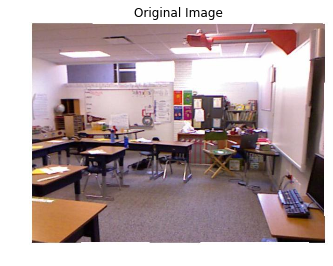

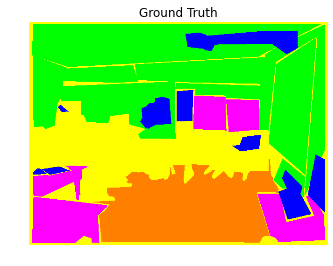

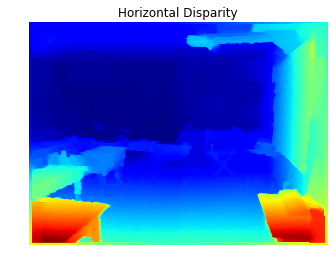

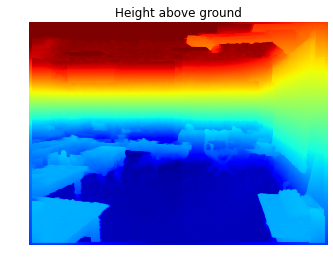

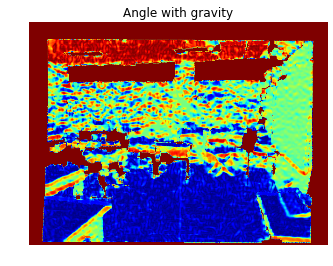

In [17]:
img = cv2.imread(image_frames[300])
gt_img = cv2.imread(gt_image_frames[300], cv2.IMREAD_UNCHANGED)
hha_img = cv2.imread(hha_image_frames[300], cv2.IMREAD_UNCHANGED) # to get in meters
#mean_px_dp = np.mean(dp_img) #Calculating the mean of depth image
#std_px_dp = np.std(dp_img)  #Calculating standard deviation of depth image
#print 'Original depth: \n', dp_img
#print ' \n Mean pixel value:', mean_px_dp
#dp_img_meanstd = (dp_img - mean_px_dp)/std_px_dp # Applying mean and standard deviation
#print '\n Standard Deviation:', std_px_dp
#print '\n Sub mean and Div std: \n', dp_img_meanstd

#dp_scaled = dp_img_meanstd + 255  #Scaling depth image 
#print '\n Scaled: \n', dp_scaled
#print '\n RGB Image:', img[:,:,0]
pl.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); pl.axis('off'); pl.title('Original Image'); pl.show();
gt_img_rgb = rgb_remapper(gt_img)
pl.imshow(gt_img_rgb); pl.axis('off'); pl.title('Ground Truth'); pl.show();

#HHA components
hozdisp = hha_img[:,:,2]
heignd = hha_img[:,:,1]
ang_grav = hha_img[:,:,0]

#Plotting HHA components 
pl.imshow(hozdisp); pl.axis('off'); pl.title('Horizontal Disparity'); pl.show();
pl.imshow(heignd); pl.axis('off'); pl.title('Height above ground'); pl.show();
pl.imshow(ang_grav); pl.axis('off'); pl.title('Angle with gravity'); pl.show();
#print gt_img[:,600]

In [18]:
H, W = model.input_height, model.input_width # H=227, W = 227
h, w = model.l_out.get_output_shape()[2:]  # h=, w=
X_data = np.zeros((N, 6, H, W), dtype=np.float32)
y_data = np.zeros((N, 1, h, w), dtype=np.float32)

In [19]:
model.l_out.get_output_shape() # Shape of final output with batch_size=8


(4, 4, 21, 21)

In [20]:
img_jit = pydnn.preprocessing.ImageBatchJitterer(x_output_shape=(H,W), y_output_shape=(h,w))
#x_output_shape= (227,227)
#y_output_shape = 

In [21]:
# Calculating mean values of R, G , B and H, H, A
R=G=B=HE=HO=A=0
for n in xrange(N):
    BGR = cv2.imread(image_frames[n])
    AHH = cv2.imread(hha_image_frames[n], cv2.IMREAD_UNCHANGED)
    B = B+np.mean(BGR[:,:,0])
    G = G+np.mean(BGR[:,:,1])
    R = R+np.mean(BGR[:,:,2])
    A = A+np.mean(AHH[:,:,0]) #Angle of normal with gravity
    HE = HE+np.mean(AHH[:,:,1]) #height above the ground
    HO = HO+np.mean(AHH[:,:,2]) #horizontal disparity

B=B/N ; G=G/N ; R=R/N
A=A/N ; HE=HE/N; HO=HO/N    
print 'Average value B:', B ; print 'Average value G:',G; print 'Average value R:',R
print 'Average value A:', A ; print 'Average value HE:',HE; print 'Average value HO:',HO

Average value B: 99.9268920915
Average value G: 104.732757449
Average value R: 122.430744629
Average value A: 137.527027959
Average value HE: 102.544806327
Average value HO: 134.543461014


In [22]:
for n in xrange(N):
    img = cv2.imread(image_frames[n])
    depth = cv2.imread(hha_image_frames[n], cv2.IMREAD_UNCHANGED)
    #Preprocessing on depth imssssage ....
    #mean_depth = np.mean(depth) #Calculating the mean of depth image
    #std_depth = np.std(depth)  #Calculating standard deviation of depth image
    #meanstd_depth = (depth - mean_depth)/std_depth
    #depth_scaled = meanstd_depth + 255  #Scaling 
    
    new = np.zeros((480,640,6)) # temporary variable to store the RGB+D
    new[:,:,0] = img[:,:,0]-B
    new[:,:,1] = img[:,:,1]-G
    new[:,:,2] = img[:,:,2]-R
    new[:,:,3] = depth[:,:,0]-A
    new[:,:,4] = depth[:,:,1]-HE
    new[:,:,5] = depth[:,:,2]-HO
    new = np.asarray(cv2.resize(new,(W,H), fx = 0, fy = 0, interpolation = cv2.INTER_LINEAR)).copy()
    
    gt_img = cv2.imread(gt_image_frames[n],cv2.IMREAD_UNCHANGED)
    gt_img = np.asarray(cv2.resize(gt_img,(w,h), fx=0, fy=0, interpolation=cv2.INTER_NEAREST)).copy()#image.nearest   
    
    X_data[n] = np.rollaxis(new, 2).astype(np.float32)  # shape is (6,227,227) 
    y_data[n,0] = np.asarray(gt_img).astype(np.float32) #shape is (1,227,227)

print 'X_data Shape:', X_data.shape
print 'y_data Shape:', y_data.shape

X_data Shape: (1449, 6, 500, 500)
y_data Shape: (1449, 1, 21, 21)


In [23]:
#mean_px = X_data[train_idx].mean((0, 2, 3), keepdims=True) #Calculating the mean of pixel value

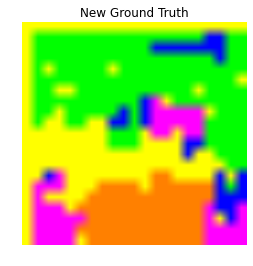

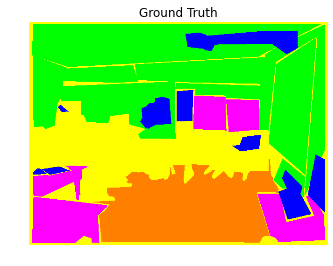

In [29]:
#visualizing the a smaple input ground truth image after dimension adjustment
newgt=y_data[300,0]
newgt_rgb = rgb_remapper(newgt)
pl.imshow(newgt_rgb); pl.axis('off'); pl.title('New Ground Truth'); pl.show();
pl.imshow(gt_img_rgb); pl.axis('off'); pl.title('Ground Truth'); pl.show();
#mean_px.shape, mean_px

In [25]:
#X_data -= mean_px


In [26]:
X_data_j, y_data_j = img_jit.preprocess(X_data[train_idx], y_data[train_idx]) # preprocessing training data
print 'Shape of X_data_j :', X_data_j.shape
print 'Shape of y_data_j :', y_data_j.shape

Shape of X_data_j : (795, 6, 500, 500)
Shape of y_data_j : (795, 1, 21, 21)


In [27]:
X_shared = theano.shared(X_data_j) # Creating the theano shared variable and copying training data to GPU
y_shared = theano.shared(y_data_j)

In [28]:
#Defining Theano varaibles
X_batch = model.X
y_batch = model.y1 
batch_index = T.iscalar('b_ix')
batch_slice = slice(batch_index*model.batch_size, (batch_index+1)*batch_size)


In [29]:
#Defining outputs 
out = model.l_out.get_output(X_batch) # ??(predicted output) // the FCN is called here
dout = model.l_out.get_output(X_batch, deterministic = True) #difference b/w both outputs


In [30]:
#Defining loss
loss = model.get_loss(out, y_batch) + 0.0005*model.get_l2_norm()

In [31]:
#Defining error
err = model.get_error_rate(out, y_batch)
err_test = model.get_error_rate(dout,y_batch)

In [32]:
#Getting and updating all the paramters of model
all_params = model.get_params()
updates = lasagne.updates.momentum(loss, all_params, 0.0001, 0.9)
print 'All parameters of model:\n', all_params

All parameters of model:
[conv1_1.W, conv1_1.b, conv1_2.W, conv1_2.b, conv2_1.W, conv2_1.b, conv2_2.W, conv2_2.b, conv3_1.W, conv3_1.b, conv3_2.W, conv3_2.b, conv3_3.W, conv3_3.b, conv4_1.W, conv4_1.b, conv4_2.W, conv4_2.b, conv4_3.W, conv4_3.b, conv5_1.W, conv5_1.b, conv5_2.W, conv5_2.b, conv5_3.W, conv5_3.b, conv6_1.W, conv6_1.b, conv7_1.W, conv7_1.b, score.W, score.b, conv_out_nin.W, conv_out_nin.b]


In [33]:
pred_fn = theano.function([batch_index],[model.get_prediction_image(dout),err_test], 
                          givens={X_batch: X_shared[batch_slice], y_batch: T.cast(y_shared[batch_slice], 'int32')})

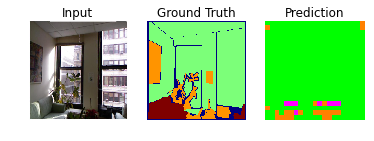

Error: 0.449392706156


In [34]:
yi = 3
X_data_j, y_data_j = img_jit.preprocess(X_data[test_idx], y_data[test_idx], deterministic=True)
X_shared.set_value(X_data_j, borrow=True) #settin the data to testing set
y_shared.set_value(y_data_j, borrow=True)
[yhat_b,error] = pred_fn(0) # output shape=
yhat00 = yhat_b[yi,0]+1  # why adding one ?
img = np.asarray(Image.open(image_frames[test_idx[yi]]).resize((256, 256)))
gt_img = np.asarray(Image.open(gt_image_frames[test_idx[yi]]).resize((256, 256)))

#Showing results
pl.subplot(1, 3, 1)
pl.imshow(img); pl.axis('off'); pl.title('Input'); 
pl.subplot(1, 3, 2)
pl.imshow(gt_img, interpolation='nearest'); pl.axis('off'); pl.title('Ground Truth')
pl.subplot(1, 3, 3)
yhat00_rgb = rgb_remapper(yhat00)
pl.imshow(yhat00_rgb, interpolation='nearest'); pl.axis('off'); pl.title('Prediction')
pl.show()
print 'Error:', error

In [35]:
#Batch training takes input batch index and gives loss as output, apply updates to loss
#iter_train = theano.function([batch_index], loss, updates=updates, allow_input_downcast=True,
#                            givens={X_batch: X_shared[batch_slice], y_batch: T.cast(y_shared[batch_slice], 'int32')})  

In [36]:
#Batch training takes input batch index and gives loss and error as output, apply updates to loss
iter_train = theano.function([batch_index], [loss, err], updates=updates, allow_input_downcast=True,
                            givens={X_batch: X_shared[batch_slice], y_batch: T.cast(y_shared[batch_slice], 'int32')})

In [37]:
num_batches = len(train_idx)//batch_size
num_batches

198

In [ ]:
for epoch in xrange(120):
    X_data_j, y_data_j = img_jit.preprocess(X_data[train_idx], y_data[train_idx])
    X_shared.set_value(X_data_j, borrow=True) # setting the data to training set
    y_shared.set_value(y_data_j, borrow=True)
    losses = []
    errors = []
    for bi in xrange(num_batches):
        los, erro = iter_train(bi)
        losses.append(los)
        errors.append(erro)
        #print('loss: {}'.format(loss_value))
    print('epoch {}, average loss: {}, average error: {} \n'.format(epoch, np.mean(losses), np.mean(errors))), 

In [ ]:
num_batches_validate = len(test_idx)//batch_size
X_data_j, y_data_j = img_jit.preprocess(X_data[test_idx], y_data[test_idx], deterministic=True)
X_shared.set_value(X_data_j, borrow=True)
y_shared.set_value(y_data_j, borrow=True)
for bi in xrange(num_batches_validate):    
    [yhat_b,erro] = pred_fn(bi) #testing is also batch type??
    print('batch {}, error: {}'.format(bi, erro))
    #printing result every 10th validation batch
    if(bi%40)==0:
        for yi in xrange(batch_size):
            yhat00 = yhat_b[yi,0]+1
            name = 'pred_bat'+ str(bi)+'_yi'+str(yi)+'.png'
            cv2.imwrite(name,yhat00)
            img = np.asarray(Image.open(image_frames[test_idx[(bi*batch_size)+yi]]).resize((227, 227)))
            gt_img = np.asarray(Image.open(gt_image_frames[test_idx[(bi*batch_size)+yi]]).resize((227, 227)))
            #print 'output shape:', yhat_b.shape
            #Plotting test results
            pl.subplot(1, 3, 1)
            pl.imshow(img); pl.axis('off'); pl.title('Input');
            pl.subplot(1, 3, 2)
            pl.imshow(gt_img, interpolation='nearest'); pl.axis('off'); pl.title('Ground Truth')
            pl.subplot(1, 3, 3)
            yhat00_rgb = rgb_remapper(yhat00)
            pl.imshow(yhat00_rgb, interpolation='nearest'); pl.axis('off'); pl.title('Prediction')
            pl.show()
